# Starter Notebook

Install and import required libraries

In [3]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

## Load Tokenizer and Preprocess Data

In [5]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [6]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [8]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=num_labels, 
    id2label=id2label,
    label2id={v: k for k, v in id2label.items()})
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [10]:
# Split the original training set, increse the size of test size
split_datasets = tokenized_dataset.train_test_split(test_size=10000, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(eval_dataset)}")

Train set size: 110000
Validation set size: 10000


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [12]:
# PEFT Config
peft_config = LoraConfig(
    r=6,
    lora_alpha=16,
    lora_dropout=0.2,
    bias = 'lora_only',
    target_modules = ['query','value','out_proj','key'],
    task_type="SEQ_CLS",
    modules_to_save=["classifier"],
)


In [13]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=num_labels, 
    id2label=id2label,
    label2id={v: k for k, v in id2label.items()})
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): Mod

In [15]:
print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.base_layer.bias
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight


In [16]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 957,724 || all params: 125,578,784 || trainable%: 0.7626


## Training Setup

In [18]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [19]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    
    logging_steps=100,
    learning_rate=3e-5,
    num_train_epochs=1,
    max_steps=3600,
    
    use_cpu=False,
    dataloader_num_workers=4,
    
    per_device_train_batch_size=24,
    per_device_eval_batch_size=96,
    
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True},
    label_names=["labels"],

    lr_scheduler_type='polynomial',
    warmup_ratio=0.2,
    weight_decay=0.05,
    fp16=True,

    label_smoothing_factor=0.1,

)
model.classifier.dropout.p = 0.3
def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

In [20]:
print(model.classifier)

ModulesToSaveWrapper(
  (original_module): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=4, bias=True)
  )
  (modules_to_save): ModuleDict(
    (default): RobertaClassificationHead(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (out_proj): Linear(in_features=768, out_features=4, bias=True)
    )
  )
  (out_proj): lora.Linear(
    (base_layer): Linear(in_features=768, out_features=4, bias=True)
    (lora_dropout): ModuleDict(
      (default): Dropout(p=0.2, inplace=False)
    )
    (lora_A): ModuleDict(
      (default): Linear(in_features=768, out_features=6, bias=False)
    )
    (lora_B): ModuleDict(
      (default): Linear(in_features=6, out_features=4, bias=False)
    )
    (lora_embedding_A): ParameterDict()
    (lora_embedding_B): ParameterDict()
    (lora_magnitud

### Start Training

In [22]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.408200,1.395404,0.240700
200,1.394000,1.384620,0.240700
300,1.381000,1.372619,0.335000
400,1.364800,1.328289,0.786000
500,1.090000,0.646069,0.876100
600,0.624100,0.587570,0.885700
700,0.580100,0.577178,0.894200
800,0.560700,0.571622,0.898500
900,0.585900,0.558333,0.903300
1000,0.554600,0.560675,0.902100


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [25]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)
    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [26]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [28]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

### load the last model and check the last model accuracy

In [29]:
from transformers import AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig

peft_config = PeftConfig.from_pretrained("results/checkpoint-3600")
base_model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=4
)
peft_model = PeftModel.from_pretrained(base_model, "results/checkpoint-3600")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Check evaluation accuracy

_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:56<00:00, 22.07it/s]

Evaluation Metric: {'accuracy': 0.911}


### draw graph(with help from gpt

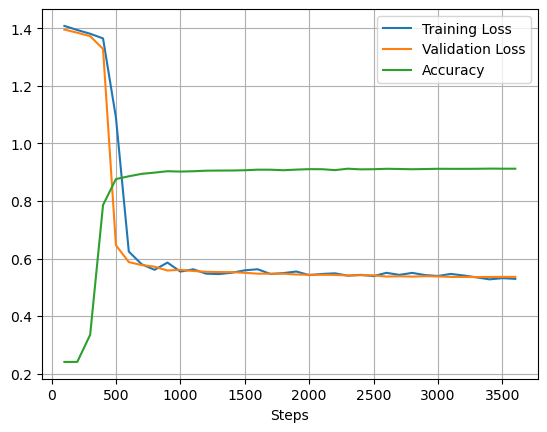

In [58]:
from transformers import TrainerState
import json
import matplotlib.pyplot as plt

with open("results/checkpoint-3600/trainer_state.json") as f:
    state = json.load(f)

steps = [log["step"] for log in state["log_history"] if "loss" in log]
loss = [log["loss"] for log in state["log_history"] if "loss" in log]
val_loss = [log["eval_loss"] for log in state["log_history"] if "eval_loss" in log]
acc = [log["eval_accuracy"] for log in state["log_history"] if "eval_accuracy" in log]

plt.plot(steps, loss, label="Training Loss")
plt.plot(steps, val_loss, label="Validation Loss")
plt.plot(steps, acc, label="Accuracy")
plt.xlabel("Steps")
plt.legend()
plt.grid()
plt.show()


### Run Inference on unlabelled dataset

In [33]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [34]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.95it/s]


Inference complete. Predictions saved to inference_output.csv


### Try using Ensemble to increase the accuracy

In [46]:
def evaluate_logits(model, test_dataset, batch_size, data_collator):
    dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator)
    model.eval()
    model.to("cuda")
    
    all_logits = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits.detach().cpu()
            all_logits.append(logits)
    
    return torch.cat(all_logits, dim=0)

In [48]:
from transformers import AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig

checkpoint_paths = [
    "results/checkpoint-1000",
    "results/checkpoint-1500",
    "results/checkpoint-2000",
    "results/checkpoint-3000",
    "results/checkpoint-2500",
    "results/checkpoint-3500",
    "results/checkpoint-3600",
]

logits_list = []

for path in checkpoint_paths:
    peft_config = PeftConfig.from_pretrained(path)
    base_model = AutoModelForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path,
        num_labels=4
    )
    model = PeftModel.from_pretrained(base_model, path)
    
    logits = evaluate_logits(model, eval_dataset, 8, data_collator)
    logits_list.append(logits)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN th

In [49]:
from sklearn.metrics import accuracy_score
import numpy as np
def evaluate_from_logits(logits, dataset):
    preds = torch.argmax(logits, dim=-1).numpy()
    labels = np.array(dataset["labels"])
    acc = accuracy_score(labels, preds)
    print(f"✅ Ensemble Accuracy: {acc:.4f}")
    return acc

### run Ensemble on test set

In [51]:
ensemble_logits = sum(logits_list) / len(logits_list)
evaluate_from_logits(ensemble_logits, eval_dataset)

✅ Ensemble Accuracy: 0.9105


0.9105

In [52]:
from transformers import AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig

checkpoint_paths = [
    "results/checkpoint-1000",
    "results/checkpoint-1500",
    "results/checkpoint-2000",
    "results/checkpoint-3000",
    "results/checkpoint-2500",
    "results/checkpoint-3500",
    "results/checkpoint-3600",
]

logits_list = []

for path in checkpoint_paths:
    peft_config = PeftConfig.from_pretrained(path)
    base_model = AutoModelForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path,
        num_labels=4
    )
    model = PeftModel.from_pretrained(base_model, path)
    
    logits = evaluate_logits(model, test_dataset, 8, data_collator)
    logits_list.append(logits)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN th

In [53]:
# find average
ensemble_logits = sum(logits_list) / len(logits_list)

# gget final prediction lable
final_preds = torch.argmax(ensemble_logits, dim=-1).numpy()

# save to file
df_output = pd.DataFrame({
    'ID': range(len(final_preds)),
    'Label': final_preds
})
df_output.to_csv(os.path.join(output_dir, "inference_output_ensemble.csv"), index=False)

print("✅ Ensemble predictions saved.")

✅ Ensemble predictions saved.
